In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image

# own imports
import sys
sys.path.append("../")

from models import DRAW

cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
print(device)

%load_ext autoreload
%autoreload 2

cuda:0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load MNIST Data

In [4]:
# Define batch size
BATCH_SIZE = 1

In [6]:
# define lambda func
def tmp_lambda(x):
    return torch.bernoulli(x)

# Load the data
mnist_data = MNIST(
    './', 
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(tmp_lambda)
    ])
)

# kwargs = {'num_workers': 1, 'pin_memory': False} if cuda else {}
data_loader = DataLoader(
    mnist_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    # **kwargs
)

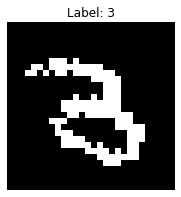

In [8]:
# plot some exampels
data_iter = iter(data_loader)
images, labels = data_iter.next()
N = 3

if N > BATCH_SIZE:
    N = BATCH_SIZE

f, ax = plt.subplots(1, N, figsize=(3*N, 6))
for i in range(N):
    if N == 1:
        ax.imshow(images[i, 0], cmap='gray')
        ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')
    else:
        ax[i].imshow(images[i, 0], cmap='gray')
        ax[i].set_title(f'Label: {labels[i]}')
        ax[i].axis('off')
plt.show()

# Instantiate Model

### Model Parameters

In [10]:
# input shape
x_shape = images.shape[2:4]
x_dim = x_shape[0] * x_shape[1]

h_dim = 256
z_dim = 16
T = 10

### Create Model

In [12]:
# Define model
model = DRAW(
    x_dim=x_dim,
    h_dim=h_dim, 
    z_dim=z_dim, 
    T=T, 
    x_shape=x_shape
).to(device)

# define optimizer and scheduler for the leraning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.5)

# Use binary cross-entropy loss
loss = nn.BCELoss(reduction='none').to(device)

# Train Model

### Hyper Parameters etc.

In [27]:
EPOCHS = 100

### Training Loop

In [28]:
# training loop
for epoch in range(EPOCHS):
    model.train()
    for x, _ in tqdm(data_loader):
        batch_size = x.size(0)

        x = x.view(batch_size, -1).to(device)
        x_hat, kld = model(x)
        x_hat = torch.sigmoid(x_hat)

        reconstruction = loss(x_hat, x).sum(1)
        kl = kld.sum(1)
        elbo = torch.mean(reconstruction + kl)

        elbo.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    scheduler.step()

    # Evaluate on test set
    # 1 forward pass in test set for loss
    model.eval()
    with torch.no_grad():

        # if epoch % 1 == 0:
          
        
        # print train loss and save sample + recon
        if epoch % 1 == 0:
            print("\nLoss at step {}: {}".format(epoch, elbo.item()))
            x_sample = model.sample()
            save_image(x_hat, "reconstruction-{}.jpg".format(epoch))
            save_image(x_sample, "sample-{}.jpg".format(epoch))

  0%|          | 227/60000 [02:06<9:16:31,  1.79it/s]


KeyboardInterrupt: 